In [346]:
from pathlib import Path

import polars as pl

import seaborn as sns
from matplotlib import pyplot as plt

In [347]:
def get_data_dict(fitbitdata_directory: Path) -> dict[str, list[Path]]:
    """
    Traverse the specified directory to collect CSV files, organizing them by their parent directory names.

    Parameters:
    fitbitdata_directory (Path): The root directory containing subdirectories with CSV files.

    Returns:
    Dict[str, List[Path]]: A dictionary where each key is the name of a subdirectory, and the corresponding value is a list of Paths to the CSV files within that subdirectory.

    """

    data_collection = {}

    for subdir in fitbitdata_directory.glob("*"):
        for file in subdir.glob("*.csv"):
            topic = subdir.parts[-1]
            if topic in data_collection.keys():
                data_collection[topic].append(file)
            else:
                data_collection[topic] = [file]

    return data_collection


def plot_timeseries(
    df: pl.DataFrame,
    timestamp_col: str,
    mean_col: str,
    quantile_cols: dict | None = None,
    xlabel: str = "",
    ylabel: str = "",
    title: str = "",
    legend: bool = True,
):
    """
    Plots a time series with mean values and shaded quantile ranges.

    Parameters:
    - df: polars.DataFrame
        The DataFrame containing the data.
    - timestamp_col: str
        The name of the column containing timestamp data.
    - mean_col: str
        The name of the column containing mean values to plot.
    - quantile_cols: dict, optional
        A dictionary specifying the quantile columns to shade, with keys as labels and values as tuples of (lower_quantile_col, upper_quantile_col).
        Example: {'IQR (25th to 75th percentile)': ('rmssd_Q25%', 'rmssd_Q75%')}
    - xlabel: str, optional
        Label for the x-axis.
    - ylabel: str, optional
        Label for the y-axis.
    - title: str, optional
        Title of the plot.
    """

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=timestamp_col, y=mean_col, label=mean_col, color="blue")

    if quantile_cols:
        for label, (lower_col, upper_col) in quantile_cols.items():
            if lower_col in df.columns and upper_col in df.columns:
                plt.fill_between(
                    df[timestamp_col],
                    df[lower_col],
                    df[upper_col],
                    alpha=0.3,
                    label=label,
                )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)

    if legend:
        plt.legend()

    plt.tight_layout()

    plt.show()


def plot_time_series_all_columns(
    df: pl.DataFrame, time_column: str, date_column: str = None, legend: bool = False
):
    """
    Plots all numeric columns in a Polars DataFrame against a specified time column.

    Parameters:
    - df: pl.DataFrame
        Polars DataFrame containing the data to plot.
    - time_column: str
        The column name representing the timestamp for the x-axis.
    - date_column: str, optional
        An optional column for date to aggregate by or display if available.

    Returns:
    None
    """
    # Ensure time column is datetime type
    if time_column not in df.columns:
        raise ValueError(f"{time_column} is not a valid column in the DataFrame.")

    if not isinstance(df[time_column].dtype, pl.Datetime):
        raise ValueError(f"{time_column} is not of datetime type.")

    # Select numeric columns
    numeric_columns = [
        col
        for col, dtype in zip(df.columns, df.schema.values())
        if dtype.is_numeric() and col not in {time_column, date_column}
    ]

    if not numeric_columns:
        raise ValueError("No numeric columns found in the DataFrame to plot.")

    # Convert the DataFrame to pandas for plotting
    pandas_df = df.to_pandas()

    # Set up the figure
    plt.figure(figsize=(14, len(numeric_columns) * 3))

    for i, col in enumerate(numeric_columns, 1):
        plt.subplot(len(numeric_columns), 1, i)
        plt.plot(pandas_df[time_column], pandas_df[col], label=col, alpha=0.8)
        plt.title(col)
        plt.xlabel("Time")
        plt.ylabel(col)
        plt.grid(True)
        if date_column and date_column in pandas_df.columns:
            plt.xticks(pandas_df[time_column][:: len(pandas_df) // 10], rotation=45)
        else:
            plt.xticks(rotation=45)
        if legend:
            plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

In [348]:
project = Path().home().cwd()

if project.parts[-1] != "fitbitData":
    project = project.parent


data = project / "data"
fitbitdata = data / "Takeout" / "Fitbit"

data_collection = get_data_dict(fitbitdata)

In [349]:
step_files = filter(
    lambda p: "steps" in p.parts[-1], data_collection["Physical Activity_GoogleData"]
)

query = pl.scan_csv(list(step_files), schema_overrides={"timestamp": pl.Datetime})

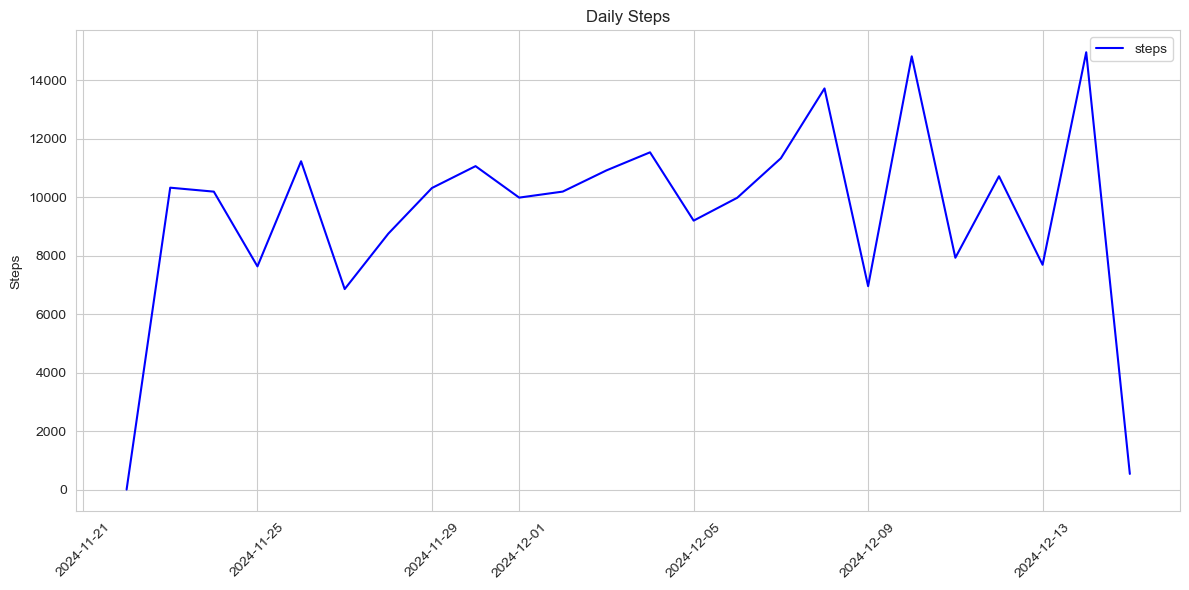

In [350]:
query = query.group_by_dynamic("timestamp", every="1d", closed="left").agg(
    pl.col("steps").sum()
)

steps_df = query.collect()

plot_timeseries(
    df=steps_df,
    timestamp_col="timestamp",
    mean_col="steps",
    xlabel="",
    ylabel="Steps",
    title="Daily Steps",
    legend=False,
)

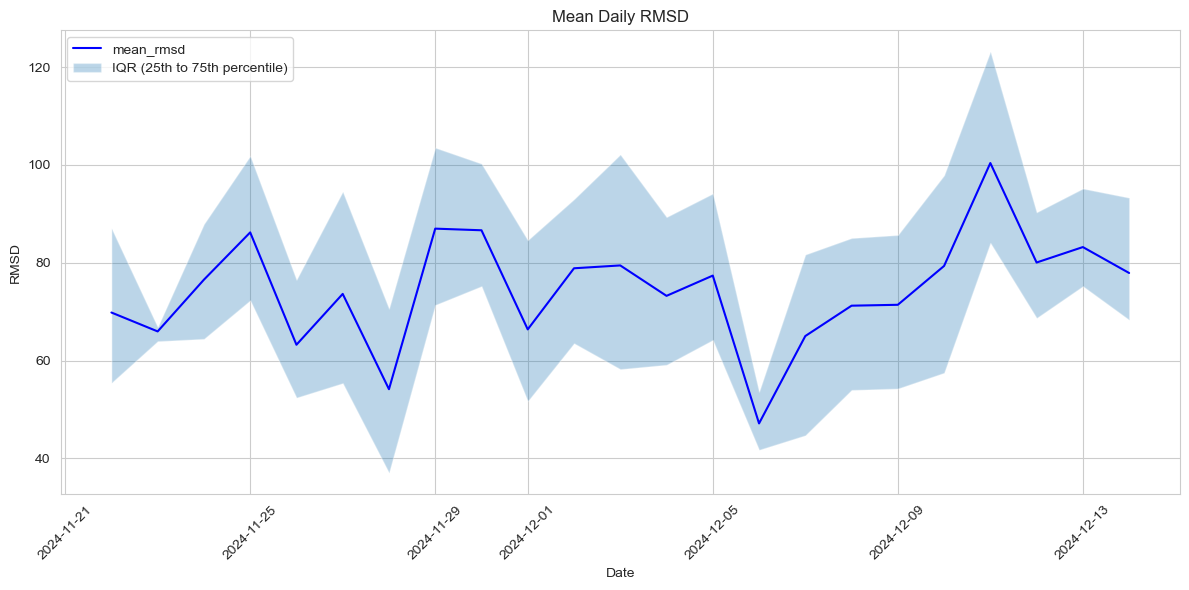

In [351]:
hrv_files = filter(
    lambda p: "Heart Rate Variability Details" in p.parts[-1],
    data_collection["Heart Rate Variability"],
)


query = pl.scan_csv(list(hrv_files), schema_overrides={"timestamp": pl.Datetime}).sort(
    by="timestamp"
)

query = query.group_by_dynamic("timestamp", every="1d", closed="left").agg(
    pl.col("rmssd").mean().alias("mean_rmsd"),
    pl.col("rmssd").quantile(0.25).name.suffix("_Q25%"),
    pl.col("rmssd").quantile(0.5).name.suffix("_Q50%"),
    pl.col("rmssd").quantile(0.75).name.suffix("_Q75%"),
    pl.col("rmssd").quantile(1).name.suffix("_Q100%"),
)


hrv_df = query.collect()

quantile_columns = {
    "IQR (25th to 75th percentile)": ("rmssd_Q25%", "rmssd_Q75%"),
}

plot_timeseries(
    df=hrv_df,
    timestamp_col="timestamp",
    mean_col="mean_rmsd",
    quantile_cols=quantile_columns,
    xlabel="Date",
    ylabel="RMSD",
    title="Mean Daily RMSD",
)

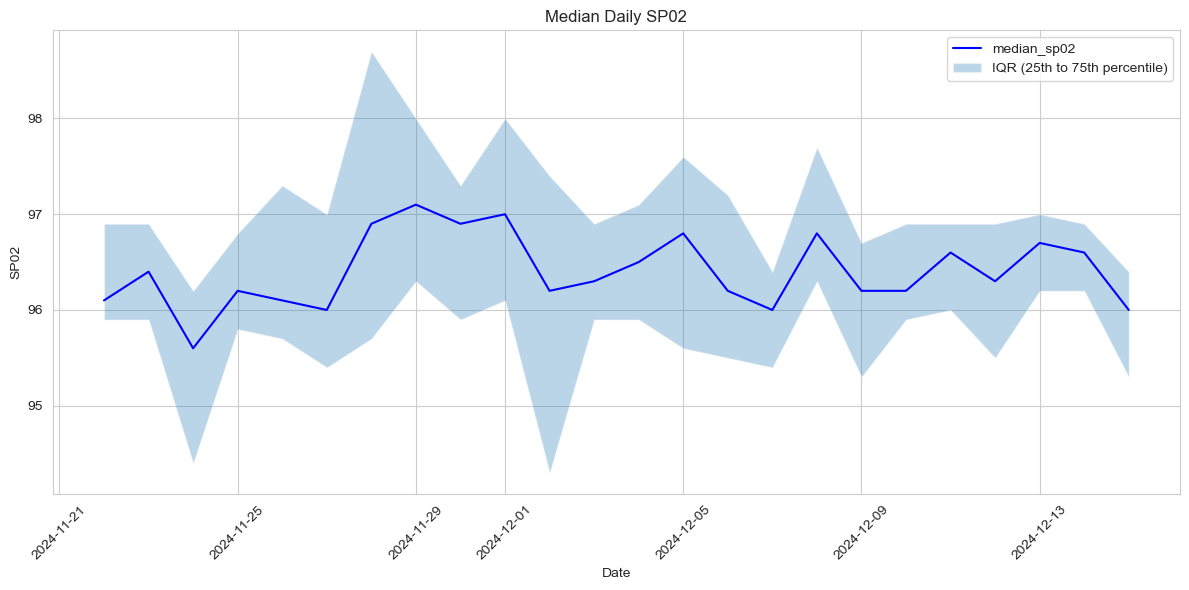

In [352]:
sp02_files = filter(
    lambda p: "Minute SpO2" in p.parts[-1], data_collection["Oxygen Saturation (SpO2)"]
)


query = (
    pl.scan_csv(list(sp02_files), schema_overrides={"timestamp": pl.Datetime})
    .sort(by="timestamp")
    .rename({"value": "sp02"})
)

query = query.group_by_dynamic("timestamp", every="1d", closed="left").agg(
    pl.col("sp02").median().alias("median_sp02"),
    pl.col("sp02").quantile(0.25).name.suffix("_Q25%"),
    pl.col("sp02").quantile(0.5).name.suffix("_Q50%"),
    pl.col("sp02").quantile(0.75).name.suffix("_Q75%"),
    pl.col("sp02").quantile(1).name.suffix("_Q100%"),
)


sp02_df = query.collect()

quantile_columns = {
    "IQR (25th to 75th percentile)": ("sp02_Q25%", "sp02_Q75%"),
}

plot_timeseries(
    df=sp02_df,
    timestamp_col="timestamp",
    mean_col="median_sp02",
    quantile_cols=quantile_columns,
    xlabel="Date",
    ylabel="SP02",
    title="Median Daily SP02",
)

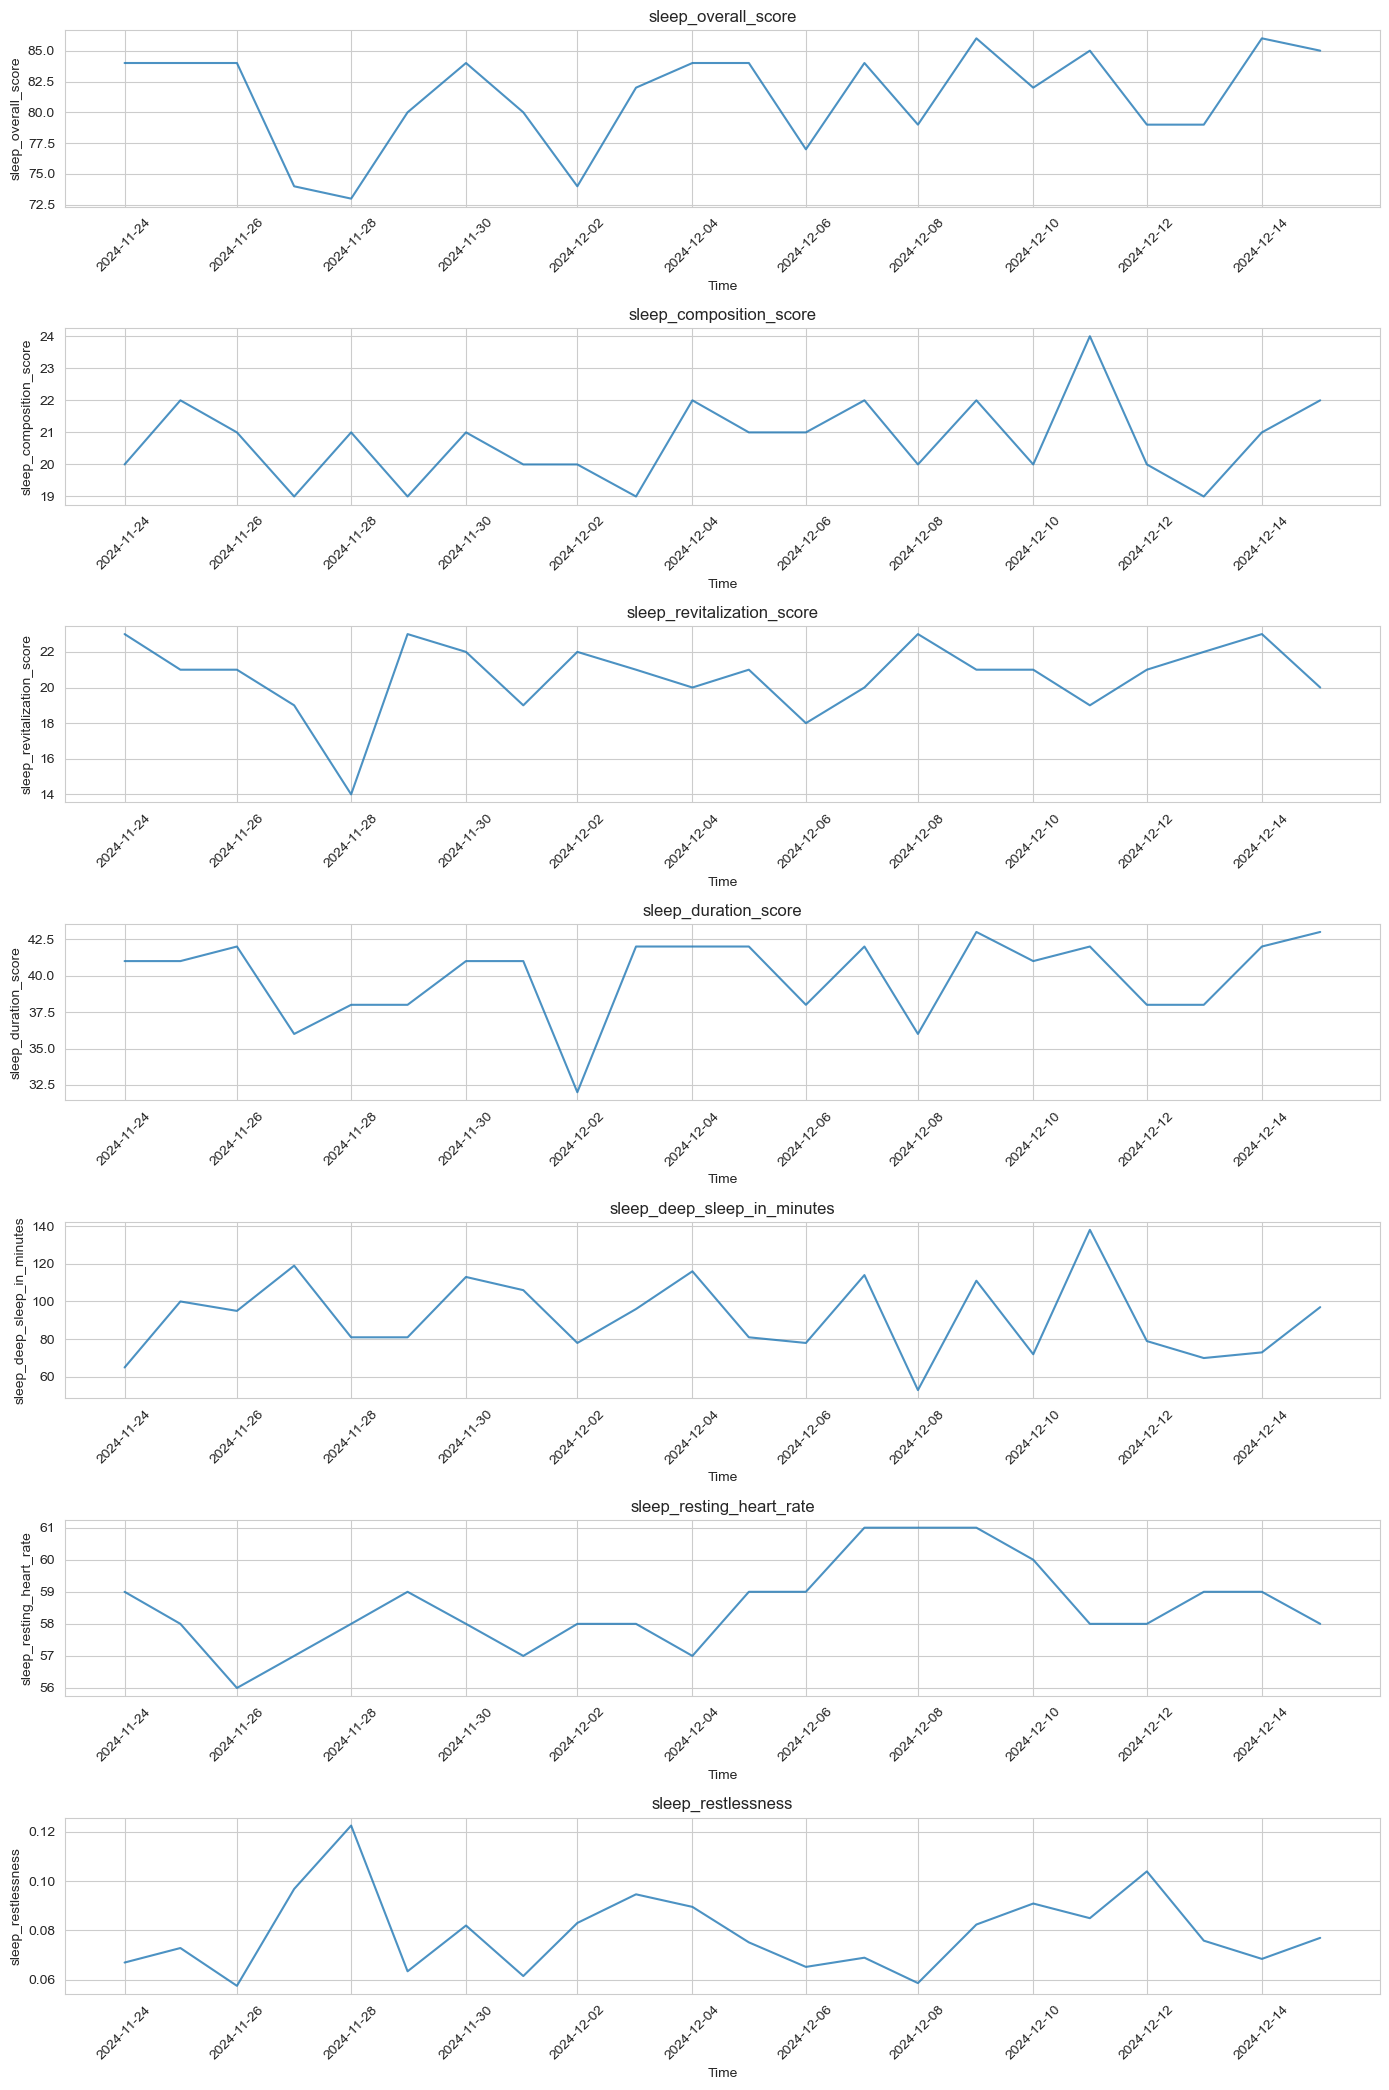

In [353]:
sleep_files = filter(
    lambda p: "sleep_score" in p.parts[-1], data_collection["Sleep Score"]
)


query = (
    pl.scan_csv(list(sleep_files), schema_overrides={"timestamp": pl.Datetime})
    .sort(by="timestamp")
    .drop("sleep_log_entry_id")
).select(pl.col("*").name.prefix("sleep_"))

query = query.with_columns(pl.col("sleep_timestamp").dt.date().alias("date"))

sleep_df = query.collect()


plot_time_series_all_columns(sleep_df, "sleep_timestamp", "date")

In [354]:
df = (
    steps_df.select(pl.col(["timestamp", "steps"]))
    .join(hrv_df.select(pl.col(["timestamp", "mean_rmsd"])), on="timestamp")
    .join(sp02_df.select(pl.col(["timestamp", "median_sp02"])), on="timestamp")
)

df = df.with_columns(pl.col("timestamp").dt.date().alias("date"))

df = df.join(sleep_df, on="date")
df = df.drop("date", "sleep_timestamp")
df = df.with_columns(pl.col("timestamp").dt.date().alias("date")).drop("timestamp")
df = df.select([pl.col("date"), pl.exclude("date")])
df

date,steps,mean_rmsd,median_sp02,sleep_overall_score,sleep_composition_score,sleep_revitalization_score,sleep_duration_score,sleep_deep_sleep_in_minutes,sleep_resting_heart_rate,sleep_restlessness
date,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64
2024-11-24,10188,76.533101,95.6,84,20,23,41,65,59,0.067005
2024-11-25,7635,86.195319,96.2,84,22,21,41,100,58,0.072886
2024-11-26,11226,63.226383,96.1,84,21,21,42,95,56,0.057569
2024-11-27,6860,73.621813,96.0,74,19,19,36,119,57,0.096807
2024-11-28,8753,54.138058,96.9,73,21,14,38,81,58,0.122492
…,…,…,…,…,…,…,…,…,…,…
2024-12-10,14810,79.337653,96.2,82,20,21,41,72,60,0.090909
2024-12-11,7930,100.379667,96.6,85,24,19,42,138,58,0.084974
2024-12-12,10714,80.040596,96.3,79,20,21,38,79,58,0.103924


In [355]:
pdf = df.drop("date").corr().to_pandas()
pdf.index = pdf.columns
pdf

,steps,mean_rmsd,median_sp02,sleep_overall_score,sleep_composition_score,sleep_revitalization_score,sleep_duration_score,sleep_deep_sleep_in_minutes,sleep_resting_heart_rate,sleep_restlessness
steps,1.000000,-0.080505,0.067799,0.211382,-0.135747,0.370027,0.086770,-0.443389,0.220339,-0.231339
mean_rmsd,-0.080505,1.000000,0.153029,0.375337,0.080547,0.526193,0.105747,0.220187,-0.033887,0.028550
median_sp02,0.067799,0.153029,1.000000,-0.101818,-0.053089,-0.092643,-0.052068,-0.037577,-0.052010,0.001171
sleep_overall_score,0.211382,0.375337,-0.101818,1.000000,0.516310,0.443474,0.863947,0.280122,0.194463,-0.393473
sleep_composition_score,-0.135747,0.080547,-0.053089,0.516310,1.000000,-0.284908,0.497658,0.558740,0.057417,-0.006431
sleep_revitalization_score,0.370027,0.526193,-0.092643,0.443474,-0.284908,1.000000,0.014115,-0.342063,0.278806,-0.558056
sleep_duration_score,0.086770,0.105747,-0.052068,0.863947,0.497658,0.014115,1.000000,0.403412,0.042995,-0.141577
sleep_deep_sleep_in_minutes,-0.443389,0.220187,-0.037577,0.280122,0.558740,-0.342063,0.403412,1.000000,-0.341082,0.184593
sleep_resting_heart_rate,0.220339,-0.033887,-0.052010,0.194463,0.057417,0.278806,0.042995,-0.341082,1.000000,-0.195226
sleep_restlessness,-0.231339,0.028550,0.001171,-0.393473,-0.006431,-0.558056,-0.141577,0.184593,-0.195226,1.000000
